# Title of your Work


*Teammembers*

## Introduction:

Explain why you have chosen this topic. Why is it interesting? What makes it hard to solve?



## Idea


Explain what your idea is. Whats your approach in tackling this problem. Explain in detail the general idea, the steps and also why this should lead to a better solution


## Solution

### "Naive"/default solution

Describe how the naive solution is implemented. If the default solution already has some optimization in it, explain what it is.
And then implement the solution in code. Explain what parameters can be changed in the code below.

In [3]:
# Importing all the parts we will need.
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram, plot_gate_map
from qiskit_optimization.applications import Tsp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler

import warnings

warnings.filterwarnings("ignore")

import math

pi = math.pi


# Your code here: Implementation of the naive solution

In [4]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


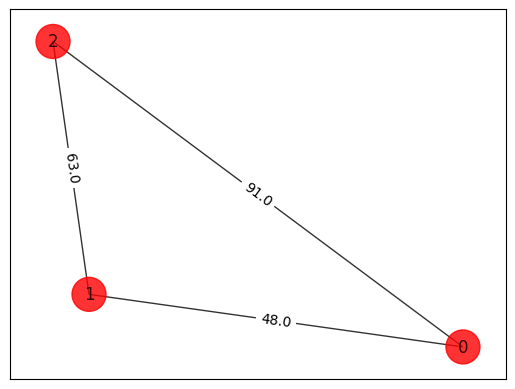

In [6]:
# Simple graph with three nodes for Traveling-Salesman-Problem (TSP) as basic introductory example
# Generating a graph of 3 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [7]:
# mapping to ising model
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [8]:
#convert to qubo
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
-1282.5 * IIIIIIIIZ
- 1282.5 * IIIIIIIZI
- 1282.5 * IIIIIIZII
- 1268.5 * IIIIIZIII
- 1268.5 * IIIIZIIII
- 1268.5 * IIIZIIIII
- 1290.0 * IIZIIIIII
- 1290.0 * IZIIIIIII
- 1290.0 * ZIIIIIIII
+ 606.5 * IIIIIIIZZ
+ 606.5 * IIIIIIZIZ
+ 606.5 * IIIIIIZZI
+ 606.5 * IIIIIZIIZ
+ 12.0 * IIIIIZIZI
+ 12.0 * IIIIIZZII
+ 12.0 * IIIIZIIIZ
+ 606.5 * IIIIZIIZI
+ 12.0 * IIIIZIZII
+ 606.5 * IIIIZZIII
+ 12.0 * IIIZIIIIZ
+ 12.0 * IIIZIIIZI
+ 606.5 * IIIZIIZII
+ 606.5 * IIIZIZIII
+ 606.5 * IIIZZIIII
+ 606.5 * IIZIIIIIZ
+ 22.75 * IIZIIIIZI
+ 22.75 * IIZIIIZII
+ 606.5 * IIZIIZIII
+ 15.75 * IIZIZIIII
+ 15.75 * IIZZIIIII
+ 22.75 * IZIIIIIIZ
+ 606.5 * IZIIIIIZI
+ 22.75 * IZIIIIZII
+ 15.75 * IZIIIZIII
+ 606.5 * IZIIZIIII
+ 15.75 * IZIZIIIII
+ 606.5 * IZZIIIIII
+ 22.75 * ZIIIIIIIZ
+ 22.75 * ZIIIIIIZI
+ 606.5 * ZIIIIIZII
+ 15.75 * ZIIIIZIII
+ 15.75 * ZIIIZIIII
+ 606.5 * ZIIZIIIII
+ 606.5 * ZIZIIIIII
+ 606.5 * ZZIIIIIII


In [14]:
def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

In [36]:
#solve qaoa
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import QAOA
from qiskit.circuit import Parameter
from qiskit.providers.fake_provider import FakeMumbaiV2

algorithm_globals.random_seed = 1234
#backend = Aer.get_backend('statevector_simulator')
backend = FakeMumbaiV2()
quantum_instance = QuantumInstance(backend=backend, seed_simulator=123, seed_transpiler=123)

beta = Parameter("β")
mixer = QuantumCircuit(n**2)
for i in range(n**2):
    mixer.rx(beta, i)

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(optimizer=cobyla, reps=1, mixer=mixer, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result_sv = qaoa.solve(qubo)

print(result_sv)
print_result(result_sv)

fval=202.0, x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_2_0=1.0, x_2_1=0.0, x_2_2=0.0, status=SUCCESS
Optimal: selection [0. 0. 1. 0. 1. 0. 1. 0. 0.], value 202.0000


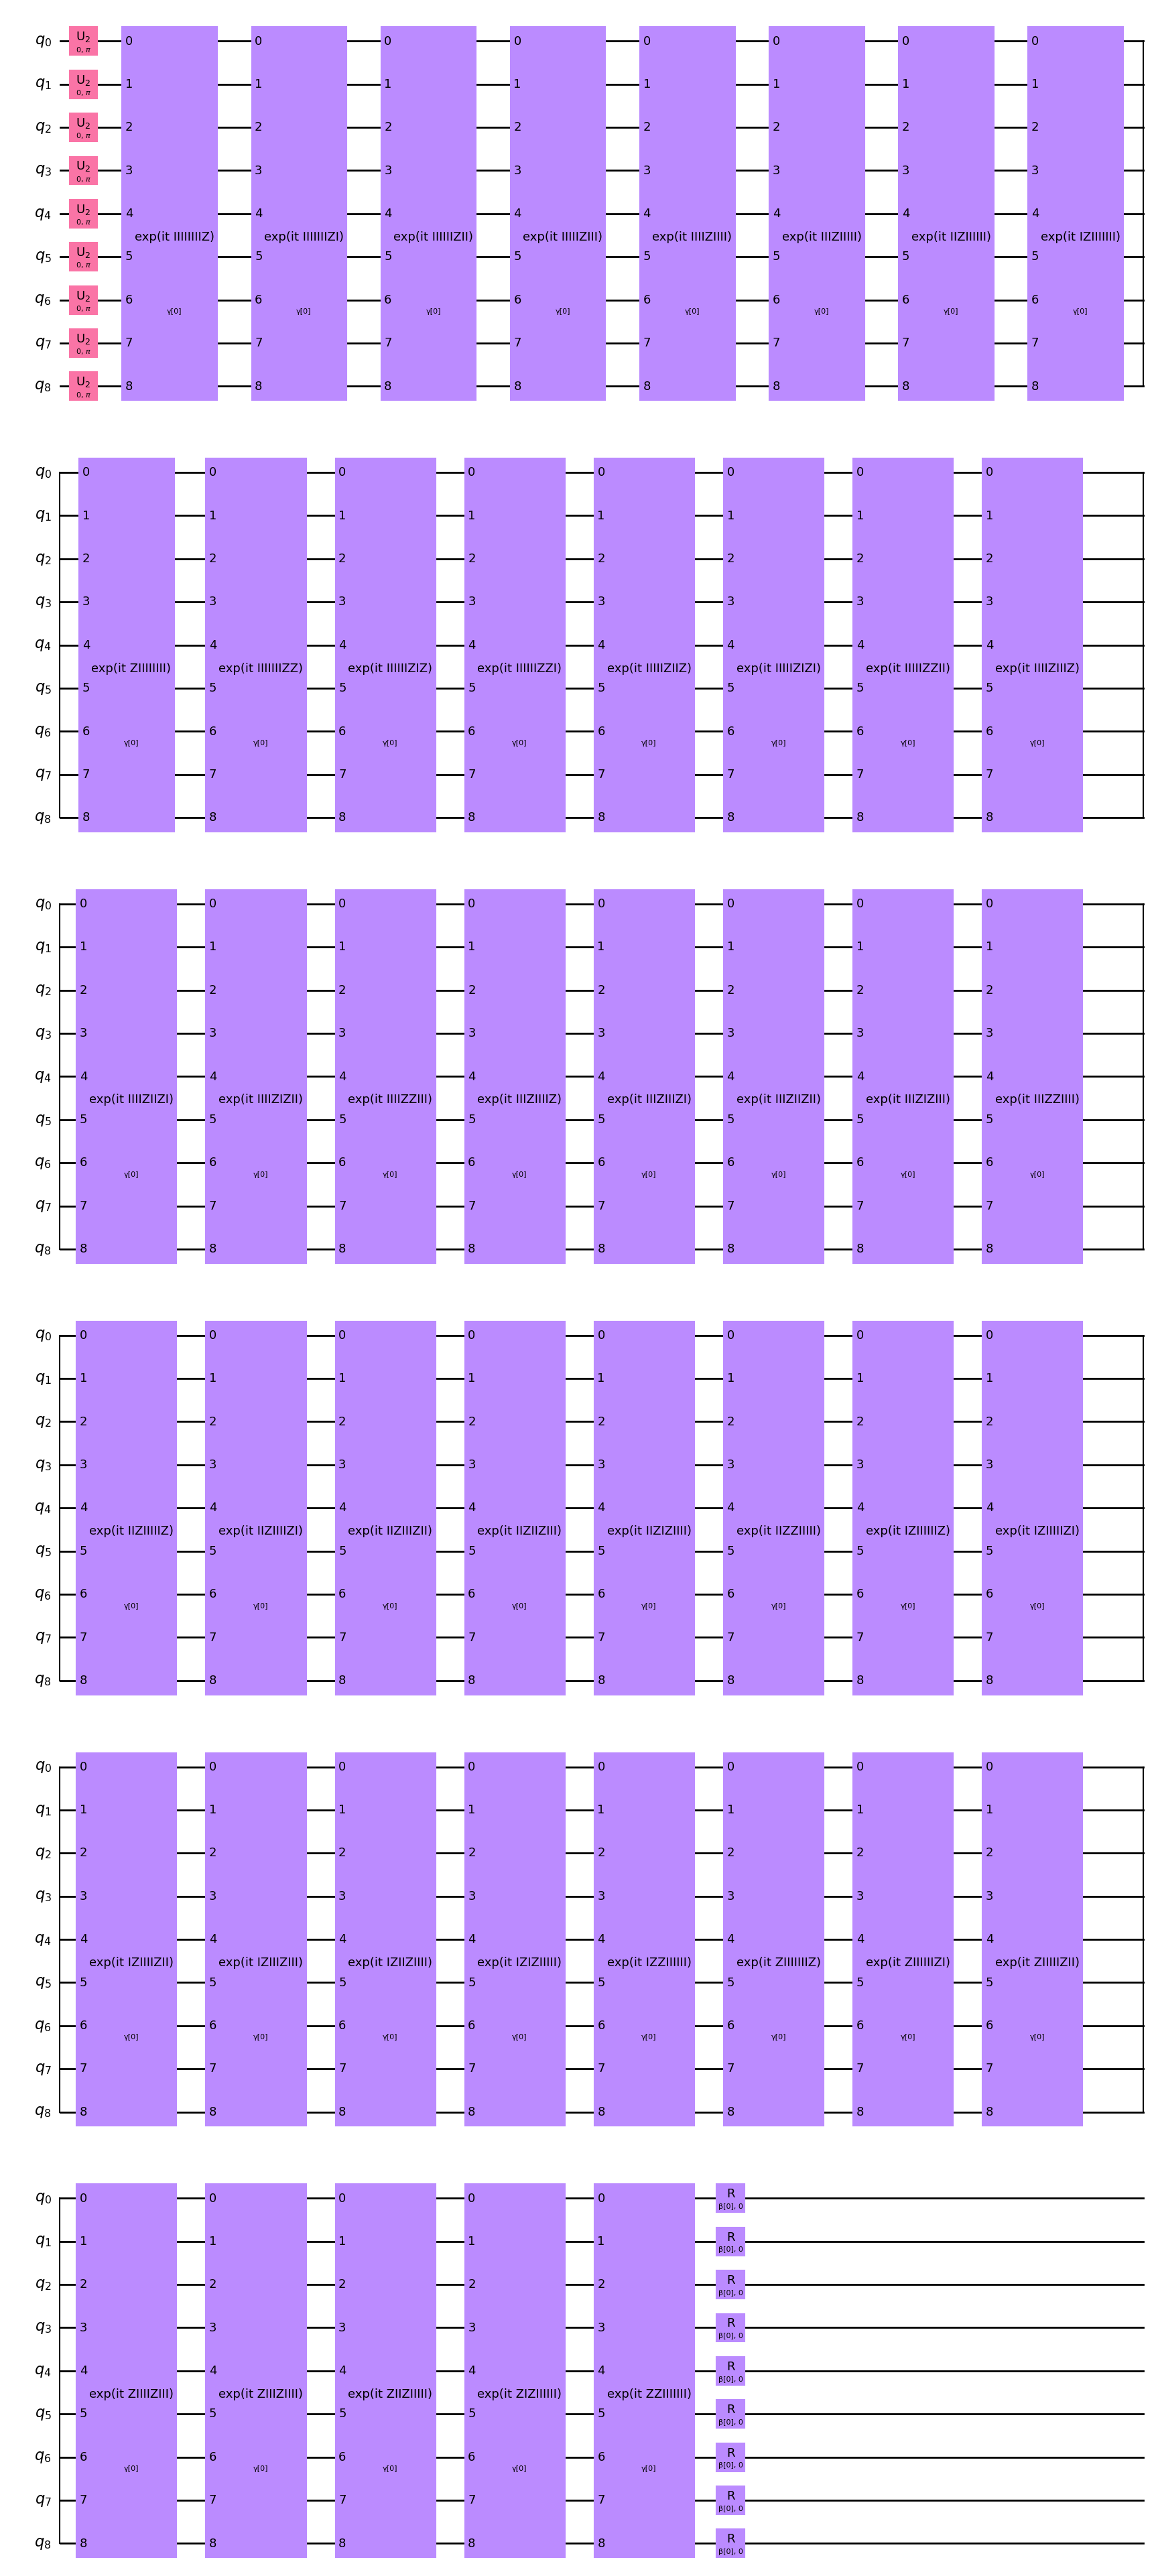

In [33]:
#qaoa_mes.ansatz.decompose().draw('mpl')

### Your solution

Explain which paramateres can be changed in the code below, how to get different results.

In [28]:

# Your code here: Implementation of the good solution

## Results

Analyse both solutions the naive and yours, and show what is better.
This can both be done theoretically (like Big O notation) or also some concrete results.
If possible show below some graphs to compare the 2 solutions helping to explain what makes your solution so good.

In [ ]:

# Your code here: Use code to show graphs